
--- Train Data (scaled) ---
+----+-------+----------+---------+---------+-----------+-----------------+--------------+--------------+--------------+------------+------------+------------+------------+
|    |   Sex |      Age |   SibSp |   Parch |      Fare |   Special_Title |   Embarked_C |   Embarked_Q |   Embarked_S |   Pclass_1 |   Pclass_2 |   Pclass_3 |   Survived |
|----+-------+----------+---------+---------+-----------+-----------------+--------------+--------------+--------------+------------+------------+------------+------------|
|  0 |     0 | 0.271174 |   0.125 |       0 | 0.0141511 |               0 |            0 |            0 |            1 |          0 |          0 |          1 |          0 |
|  1 |     1 | 0.472229 |   0.125 |       0 | 0.139136  |               0 |            1 |            0 |            0 |          1 |          0 |          0 |          1 |
|  2 |     1 | 0.321438 |   0     |       0 | 0.0154686 |               0 |            0 |            0 | 

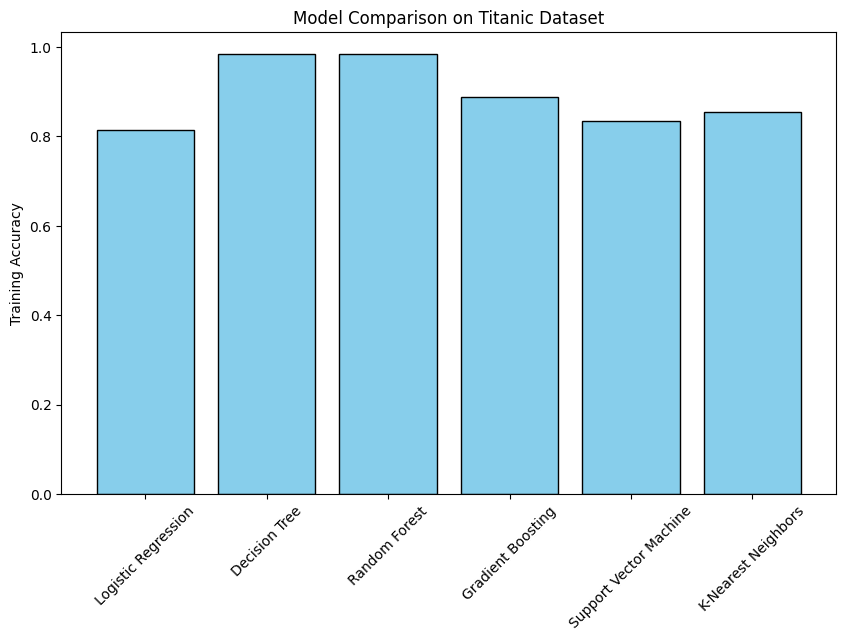

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# === 1. Load data ===
train_data = pd.read_csv("/content/drive/MyDrive/train_titanic.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_titanic.csv")

# === 2. Drop unnecessary columns ===
train_data = train_data.drop(columns=["Ticket", "Cabin", "PassengerId"])
test_passenger_ids = test_data["PassengerId"]  # keep PassengerId just in case
test_data = test_data.drop(columns=["Ticket", "Cabin", "PassengerId"])

# === 3. Extract Title from Name ===
train_data["Title"] = [x.split(".")[0].split(",")[1].strip() for x in train_data["Name"]]
test_data["Title"] = [x.split(".")[0].split(",")[1].strip() for x in test_data["Name"]]

# === 4. Special title flag ===
def is_special_title(title):
    return 0 if title in ['Mr', 'Mrs', 'Miss'] else 1

train_data['Special_Title'] = train_data['Title'].apply(is_special_title)
test_data['Special_Title'] = test_data['Title'].apply(is_special_title)

# === 5. Drop Name and Title ===
train_data = train_data.drop(columns=["Name", "Title"])
test_data = test_data.drop(columns=["Name", "Title"])

# === 6. Encode Sex (male=0, female=1) ===
train_data["Sex"] = train_data["Sex"].map({"male": 0, "female": 1})
test_data["Sex"] = test_data["Sex"].map({"male": 0, "female": 1})

# === 7. Handle missing Age ===
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
test_data["Age"] = test_data["Age"].fillna(train_data["Age"].mean())

# === 8. Handle missing Fare in test set ===
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].mean())

# === 9. One-hot encode Embarked ===
train_data = pd.concat([train_data, pd.get_dummies(train_data["Embarked"], prefix="Embarked")], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data["Embarked"], prefix="Embarked")], axis=1)
train_data = train_data.drop(columns=["Embarked"])
test_data = test_data.drop(columns=["Embarked"])

# === 10. One-hot encode Pclass ===
train_data = pd.concat([train_data, pd.get_dummies(train_data["Pclass"], prefix="Pclass")], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data["Pclass"], prefix="Pclass")], axis=1)
train_data = train_data.drop(columns=["Pclass"])
test_data = test_data.drop(columns=["Pclass"])

# === 11. Split X and y ===
y_train = train_data["Survived"]
X_train = train_data.drop(columns=["Survived"])

# === 12. Scale features ===
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_data)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=test_data.columns)

train_scaled = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)

# === 13. Preview scaled data ===
print("\n--- Train Data (scaled) ---")
print(tabulate(train_scaled.head(), headers='keys', tablefmt='psql'))

# === 14. Train and evaluate models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=800),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_train_scaled)
    acc = accuracy_score(y_train, y_pred)
    results[name] = acc

    print(f"\n🔹 Model: {name}")
    print(f"Training Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred))
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

# === 15. Plot comparison ===
plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values(), color="skyblue", edgecolor="black")
plt.ylabel("Training Accuracy")
plt.title("Model Comparison on Titanic Dataset")
plt.xticks(rotation=45)
plt.show()
